### Before data modeling, let's dive into the data to understand the problem, and to see if we can get some interesting patterns!
### This script contains 3 parts:
    - 1. Read data and import libraries
    - 2. Exploratory analysis and data visualization
    - 3. Feature importance analysis

### 1. Read Data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn import decomposition, preprocessing, cross_validation
from sklearn.cross_validation import KFold,train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [27]:
### Read Training Data and Testing Data
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
train.shape

(188318, 132)

In [30]:
### Drop id and Seperate loss
train_id = train['id']
test_id =  test['id']
train_label = train['loss']
train.drop('id',axis=1,inplace=True)
train.drop('loss',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)
print (train.shape, test.shape)

(188318, 130) (125546, 130)


### 2. Exploratory Analysis
    
    - 2.1 Target Variable - loss
    - 2.2 Categorical Variables
    - 2.3 Continuous Variables

#### 2.1 Target Variable - loss

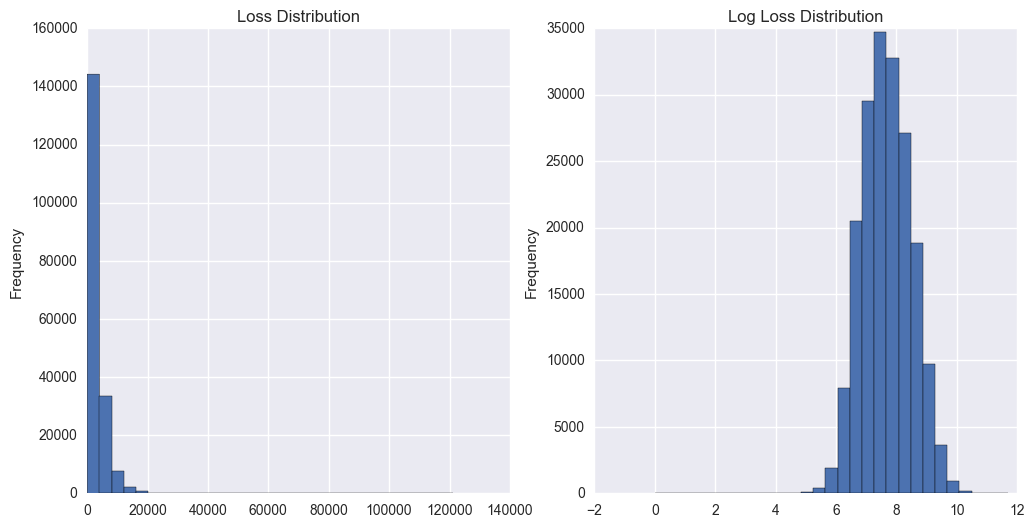

In [13]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Loss Distribution")
train_label.plot(kind='hist', grid = True, bins=30)

ax1 = fig.add_subplot(122)
ax1.set_title("Log Loss Distribution")
np.log(train_label).plot(kind='hist', grid = True, bins=30)

In [14]:
### Let's remove outliers!
train_label_log = np.log(train_label)
print("We have %d outliers." % (train_label_log[train_label_log<4].count()))
train_new = train.drop(train_label_log[train_label_log<4].index)
label_new = train_label_log.drop(train_label_log[train_label_log<4].index)
train_new = train_new.reset_index(drop=True)
label_new = label_new.reset_index(drop=True)

We have 17 outliers.


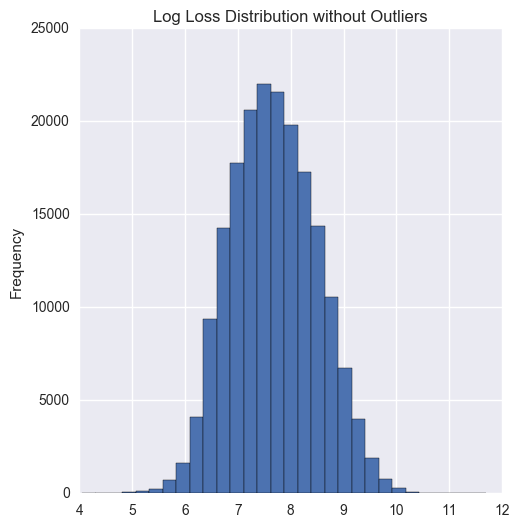

In [15]:
### Plot log loss without outliers
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Log Loss Distribution without Outliers")
label_new.plot(kind='hist', grid = True, bins=30)

#### 2.2 Categorical Variables

In [16]:
### Check number of categorical variables
features = train_new.columns
cats = [feat for feat in features if 'cat' in feat]
print("We have %d categorical variables." % (len(cats)))

We have 116 categorical variables.


In [17]:
### Check how many categories we have in each
unique = {'2':0,'2 to 10':0,'10 to 20':0, 'more than 20':0}
for i in range(len(cats)):
    count = len(train_new[cats[i]].unique())
    if count <= 2:
        unique["2"] += 1
    elif count <= 10:
        unique['2 to 10'] += 1
    elif count <=20:
        unique['10 to 20'] += 1
    else:
        unique['more than 20'] += 1

for k, v in unique.items():
    print ("%d variables has %s categories." % (v, k))

6 variables has more than 20 categories.
27 variables has 2 to 10 categories.
72 variables has 2 categories.
11 variables has 10 to 20 categories.


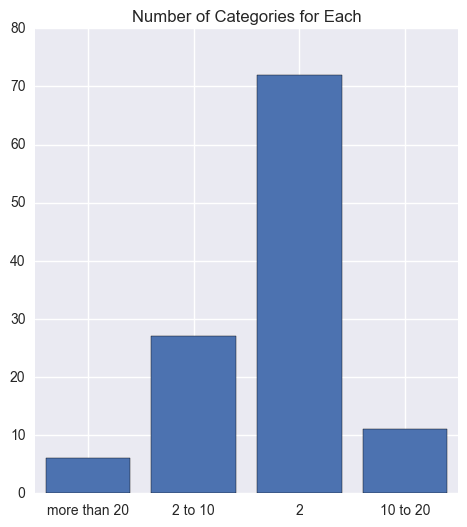

In [18]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Number of Categories for Each")
plt.bar(range(len(unique)), unique.values(), align='center')
plt.xticks(range(len(unique)), unique.keys(), fontsize=10)
plt.show() 

#### 2.3 Continuous Variables

In [19]:
conts = [feat for feat in features if 'cont' in feat]
print("We have %d numeric variables." % (len(conts)))
print(train[conts].skew())

We have 14 numeric variables.
cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
dtype: float64


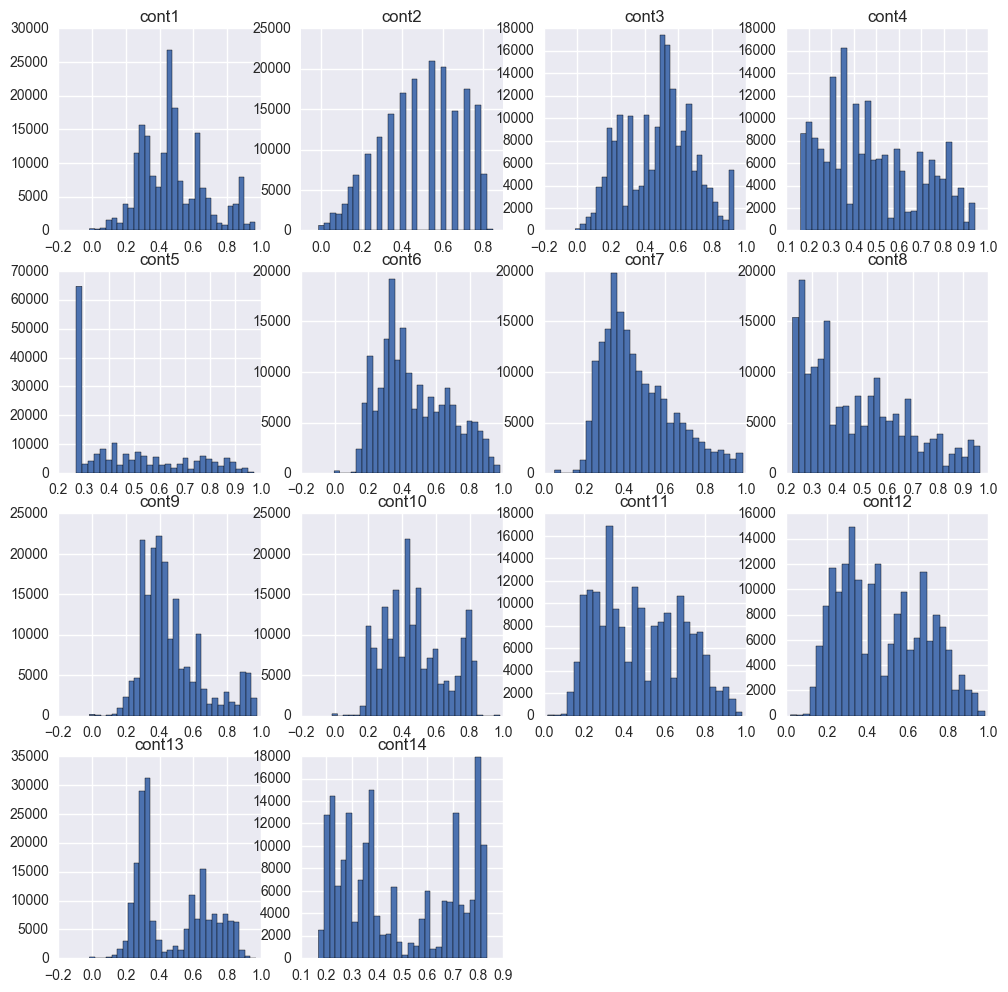

In [20]:
### Plot the distributions
fig = plt.figure(figsize=(12,12))
for i in range(14):
    #position
    ax1 = fig.add_subplot(4,4,1+i)
    ax1.set_title(conts[i])
    ax1.hist(train[conts[i]], align='left',bins = 30)

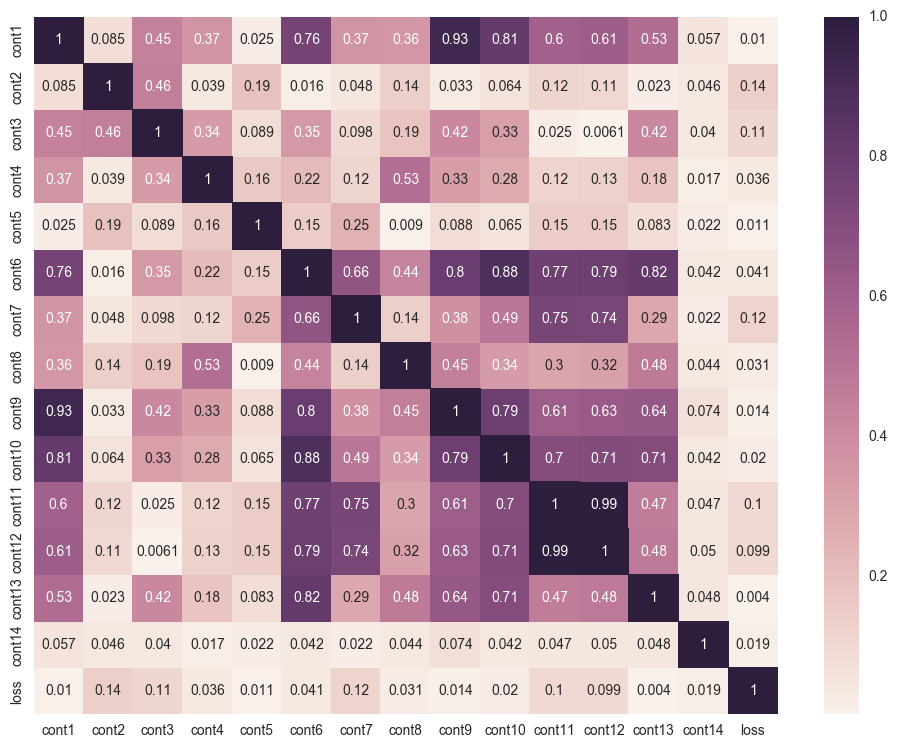

In [29]:
### Correlation Plot
plt.subplots(figsize=(12, 9))
conts.append('loss')
correlationMatrix = train[conts].corr().abs()
sns.heatmap(correlationMatrix,annot=True)
# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)
plt.show()

### 3. Feature Importance Analysis
    - 3.1 Continuous Variables
    - 3.2 Categorical Variables

#### 3.1 Feature Importance of Continuous Variables

Average MAE (1/2 training data):  851.008612404
Average MAE (other half train data):  1936.26482809


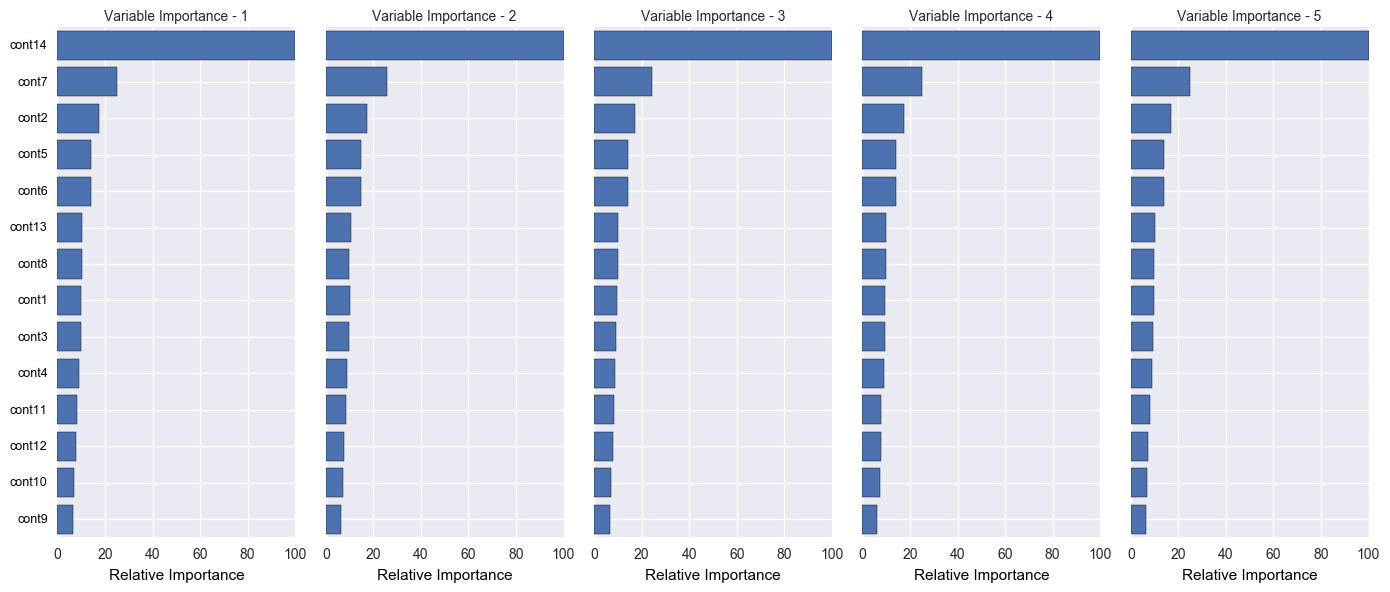

In [41]:
keepcont = conts
cont_only = train[conts]
cont_only['log-loss']=np.log(train_label)

x = cont_only[conts]
y = cont_only['log-loss']

plt.figure(figsize=(14,6))

avg_rmse = 0
avg_rmse2 = 0
for b in range(5):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5)

    # Fit an Extra Trees model to the data
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    # display the relative importance of each attribute
    feature_importance = model.feature_importances_
    
    mae = mean_absolute_error(np.exp(y_train),np.exp(model.predict(X_train)))
    mae2 = mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test)))
    
    avg_rmse+=mae
    avg_rmse2+=mae2
    ####################################################
    # Plot the feature importances
    plt.subplot(1,5,b+1)
    # make importances relative to most important feature
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    if b==0:
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    if b==0:
        plt.yticks(pos, np.array(keepcont)[sorted_idx],color='k',fontsize=9)
    else:
        plt.yticks(pos,[])
#         frame = plt.gca()
#         frame.axes.yaxis.set_ticklabels([])
    plt.xlabel('Relative Importance',color='k')
    plt.title('Variable Importance - '+str(b+1),fontsize=10)
    
    #plt.text(25,3.5,r'RMSE$_{train}$= '+str(round(np.sqrt(mse),3)),fontsize=14)
    #plt.text(25,2.5,r'RMSE$_{test}$= '+str(round(np.sqrt(mse2),3)),fontsize=14)

plt.tight_layout()

print ('Average MAE (1/2 training data): ',avg_rmse/5.0)
print ('Average MAE (other half train data): ',avg_rmse2/5.0)

### Please see the other scripts for the dimensionality reduction and data modeling!
### Thank you!